<div style="display:block">
    <div style="width: 20%; display: inline-block; text-align: left;">
        <img src="http://upload.wikimedia.org/wikipedia/en/0/0c/Mu_Sigma_Logo.jpg" style="height:75px; margin-left:0px" />
    </div>
    <div style="width: 59%; display: inline-block">
        <h1  style="text-align: center"> SMA - Drug-Temporal Association</h1><br>
        <div style="width: 100%; text-align: center; display: inline-block;"><i>Author:</i> <strong>Sruthi S, Varun Behl</strong> </div>
    </div>
    <div style="width: 20%; text-align: right; display: inline-block;">
        <div style="width: 100%; text-align: left; display: inline-block;">
            <i>Created: </i>
            <time datetime="2018-02-14" pubdate>13th Feb 2018</time>
            <i>Modified: </i>
            <time datetime="2018-02-21" pubdate>13th June 2018</time>
        </div>
    </div>
</div>

# Objective

The aim of Drug and Temporal words association is to check whether given drug and temporal mention are associated to each other or not . The association is carried out by graphical method of calculating shortest path between two words . This will help us assign mentioned drug a date , which according to our process is the date on which the drug treatment was actually started

In [9]:
# Importing the required packages
import pandas as pd
import numpy as np
import re
import re
import ast
import nltk
import networkx as nx
import xmltodict
from practnlptools.tools import Annotator

import matplotlib.pyplot as plt
import matplotlib
% matplotlib inline

In [12]:
xmlFile = 'post'+'_'+str("2696_6")+'.txt.xml'
with open(xmlOut_folderPath+xmlFile) as fd:
        doc2 = xmltodict.parse(fd.read())

In [13]:
doc2['CAS']['uima.cas.Sofa']['@sofaString']

u'For me, it went like this: - 11 months of anti-PDL1 trial until Oct 2015 when it seemed to stop yielding benefits- In Oct 2015, changed to the anti-PD1 combo of Ipilimumab/Nivolumab (Ipilimumab/Nivolumab).'

In [64]:
xmlOut_folderPath = 'C:/Users/varun.behl/Documents/test_plain_text_updated/output_from_domino/' 
ConllDependencyNode = 'org.apache.ctakes.typesystem.type.syntax.ConllDependencyNode'

# Reads the xml output from CTAKES and returns list of tuples , 
# tuples are head tail pair of each word in the sentence which used as an input for the 
# networkx package for graph creation
def conll_dict_gen(key):
    print "key",key
    
    xmlFile = 'post'+'_'+str(key)+'.txt.xml'
    
    with open(xmlOut_folderPath+xmlFile) as fd:
        doc2 = xmltodict.parse(fd.read())
    
    print doc2['CAS']['uima.cas.Sofa']['@sofaString']
    
    wi =[]
    word = []
    cpostag = []
    head = []
    token_dict = {}
    word_index = {}

    conll_string = '"'
    drug_conll_index = []
    
    sentence_start = []
    sentence_start.append(1)
    
    # Iterate over every word in the sentence
    for i in range(1,len(doc2['CAS'][ConllDependencyNode])):
        word_conll = doc2['CAS'][ConllDependencyNode][i]
        if word_conll['@id'].encode("utf-8")=='0':
            sentence_start.append(prev_token+1)
            continue
        
        #Token_dict which has word index and the cpostag
        token_dict[(word_conll['@_id']).encode("utf-8")]=[i,(word_conll['@cpostag']).encode("utf-8")]
        wi.append((word_conll['@id']).encode("utf-8"))
        wix = word_conll['@id'].encode("utf-8")
        word = word_conll['@form'].encode("utf-8")
        cpostag.append((word_conll['@cpostag']).encode("utf-8"))
        head.append((word_conll['@_ref_head']).encode("utf-8"))
        prev_token=int(word_conll['@id'])
        # word_index is a python dict with values as word token and key as index
        word_index[wix] =word

    head_index = []
    head_pos = []
    for i in range(0,len(head)):
        try:
            head_index.append(token_dict[str(head[i])][0])
            head_pos.append(token_dict[str(head[i])][1])
        except:
            # Happens when a ref_head is the start of the sentence
            head_index.append(0)
            head_pos.append(cpostag[i])
    
    #sent_list is list of tuples , tuples are head tail pair of each word in the sentence
    # This tuple is used as an input for the networkx package for graph creation
    headTail_list = []
    for i in range(0,len(head)):
        w_i = wi[i]
        h_i = str(head_index[i])
        dep_tup = (h_i,w_i)
        headTail_list.append(dep_tup)
        
    return headTail_list , word_index

In [65]:
# Function to check whether the word token from Conll output is a drug word
def isDrugMention(token):
    # custom drug list
    with open("updated_drugs.txt","r") as f:
        drug = f.read()
    try:
        
        if len(re.findall(r"\b(?=\w)"+token+r"\b(?!\w)",drug))>=1:
            #print 1
            return 1
    except:
        return 0

# When fed with a list of sorted values, it groups the indices which are consecutive
# eg: I/P: consecutive([1,2,3,7,8,11,12])
# returns : [array([1, 2, 3]), array([7, 8]), array([11, 12])]
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def getmin(l,wordsList):
    if(len(l)==len(wordsList)):
        if len(l)==1:
            return l
        else: 
            return l[0]
    else:
        return 'None'
    
def get_distance(distance_drug, distance_temp):
    try:
        distance_value=nx.shortest_path_length(graph, source=str(distance_drug), target=str(distance_temp))
    except :
        distance_value = 5
    return distance_value

def make_graph(Unique_id):
    headTail,word_index = conll_dict_gen(Unique_id)
    # This makes the graph where the nodes are the word index and the edges are the 
    graph = nx.Graph(headTail)
    return graph, headTail, word_index

In [212]:
# RETURNS: associated_list, converted_temp
# associated_list : It is a list of tuples. Tuple will be a drug mention and its associated temporal word
# converted_temp : It is a list of drug date which was converted from the temporal word w.r.t. the post date
#                  It will have drug date for the associated temporal words only
def association(row_info):
    
    u_pattern = ast.literal_eval(row_info['Updated_pattern'])
    u_words = ast.literal_eval(row_info['Updated_words'])
    temp_words = ast.literal_eval(row_info['Temporal'])
    temp_conversion = ast.literal_eval(row_info['Temp_conversion'])
    Unique_id = str(row_info['Unique_id'])
    
    Confidence = []
    
    graph, headTail, word_index = make_graph(Unique_id)
    
    associated_list = []
    converted_temp = []
    print word_index
    
    drug_list = []
    
    # For every pattern identified,
    print type(u_pattern)
    for index_d,value_d in enumerate(u_pattern):
        print index_d
        
        # In previous notebook, while pattern Extraction we are giving single index for combo drug mentions
        # Combo drug mention like (Ipilimumab/Nivolumab) will be split into 'Ipilimumab' , '/' and 'Nivolumab' 
        # seperately by CTAKES and will all have different index
        if(u_pattern[index_d]=='D'):
            Drug=u_words[index_d] 
            for r in (("/"," / "),("-"," - ")):
                Drug = Drug.replace(*r)
        print Drug       
        drug_list.append(Drug)
        print drug_list
            
    ## Ctakes has a different way of calculating positions of words in a sentence
    ## To avoid the mismatch and error while giving drug and temporal index in the laters stage 
    ## Tuple(Head,tail) is created based on ctakes indices 
    
    druglist = [] ## for checkinf if any drug mention is a combo drug
    drugelements = [] ## For finding indices/position of all drug and combo drug elemnsts
    for d_words in drug_list:  
        drugelements.append(d_words.split(' '))
        for elements in d_words.split(" "):
            druglist.append(elements)
    #wordsInDrug = len(druglist)
    print druglist
    drug_indices = np.array([int(key) for key, value in word_index.iteritems() if value in druglist])

    # Group indices which occur together
    consecutive_drug = consecutive(sorted(drug_indices))
    print "CD" , consecutive_drug
    print consecutive_drug[0],drugelements
    x = 0
    val_drug = []
    drug_names = []
    for i in range(0,len(consecutive_drug)):
        for drug in drugelements :
            if np.count_nonzero(consecutive_drug[i])==len(drug):
                val_drug.append(consecutive_drug[i][0])
                drug_names.append(" ".join(drug))
    print "val_drug", val_drug
    drug_ind = val_drug
    print drug_ind , drug_names

    # consecutive drug will have the correct drug mention so its length should be equal 
    # the number of elements in distance_drug
    # This was failing when there were brackets or double spaces between combo drugs
    try :
        assert(len(drug_ind)<=len(consecutive_drug))
    except AssertionError:
        print "Drug length mismatch"

#     if(len(drug_ind)>1):
#         print "Same drug in more than one place"

    # Some very high value
   
    actual_temporal=''

    # to extract Temporal indices out just like the drug indices we do the same set of operations again 
    # two for loops are created to calculate distance _value : shortest path between drug and temporal mentions 
    # if distance value is under given threshold of association then drug and temporal tuple is created and drug_date is appended to converted_temp
    for index_t,value_t in enumerate(temp_words):
        temporal_word=temp_words[index_t]


        temp_list = nltk.word_tokenize(temporal_word)
        print temp_list
        wordsInTemp = len(temp_list)
        temp_indices = np.array([int(key) for key, value in word_index.iteritems() if value in temp_list])

        consecutive_temp = consecutive(sorted(temp_indices))
        print 'Consecutive temp'
        print consecutive_temp
        val_temp = np.asarray(map(lambda x: getmin(x,temp_list),consecutive_temp), dtype=np.float)
        print 'val_temp'
        print val_temp
        temp_ind = np.array(val_temp[np.where(np.isnan(val_temp)!=True)], dtype=np.int)
        print temp_ind , temporal_word


        try:
            assert(len(temp_ind)==1)
        except AssertionError:
            print "Too many lists match the condition_temp"
            temp_ind = [0]


        print temporal_word,temp_ind

            # Find the shortest distance between drug and temporal element
        position = 0
        for i in drug_ind:
            
            
            # If the drug and temporal word are separated by -2 to +2 words
            print i
            print temp_ind[0]
            past = 1000
            if abs(i - temp_ind[0]) in [1,2] :
                distance_value = 1
            else:
                try:
                    # Get the shortest distance between the drug and the temp word
                    print "drugindex :" , str(i) 
                    print "temp_index :" , temp_ind[0]
                    distance_value=nx.shortest_path_length(graph, source=str(temp_ind[0]), target=str(i))
                    print "here",distance_value
                # This shouldn't happen
                except :
                    print "except"
                    distance_value = 7

            # Find the temporal word which is closest to the drug
            if distance_value<past and distance_value<=7:
                past=distance_value
                actual_temporal=temporal_word
                associated_list.append((drug_names[position],actual_temporal))
                converted_temp.append(temp_conversion[index_t])
            position +=1

            # Assign a confidence
            if  distance_value in [1,2] :
                Confidence.append('H')
            elif distance_value in [3,4,5] :
                Confidence.append('M')
            else:
                Confidence.append('L')

    return associated_list , converted_temp, Confidence

In [18]:
df = pd.read_csv('Data_100_users_roll_up_check.csv')

# temp_converted = []
# associated_list = []
# confidence_list = []

# for i in range(0,len(df)):
#     print i
#     as_list  , temp_conv = association(df.loc[i])
                                                                    
#     associated_list.append(as_list)
#     temp_converted.append(temp_conv)

In [10]:
row_info = df.loc[45]
temp_words = ast.literal_eval(row_info['Temporal'])

In [213]:
a, b ,c = association(df.loc[123])

key 3372_2
.Moving to Vemurafenib and Cobimetinib next week, although the oncologist is not hopeful, since i have a rare braf mutation, k601n.
{'24': ',', '25': 'k601n', '26': '.', '20': 'a', '21': 'rare', '22': 'braf', '23': 'mutation', '1': '.', '3': 'to', '2': 'Moving', '5': 'and', '4': 'Vemurafenib', '7': 'next', '6': 'Cobimetinib', '9': ',', '8': 'week', '11': 'the', '10': 'although', '13': 'is', '12': 'oncologist', '15': 'hopeful', '14': 'not', '17': 'since', '16': ',', '19': 'have', '18': 'i'}
<type 'list'>
0
braf
['braf']
1
Vemurafenib and Cobimetinib
['braf', 'Vemurafenib and Cobimetinib']
['braf', 'Vemurafenib', 'and', 'Cobimetinib']
CD [array([4, 5, 6]), array([22])]
[4 5 6] [['braf'], ['Vemurafenib', 'and', 'Cobimetinib']]
val_drug [4, 22]
[4, 22] ['Vemurafenib and Cobimetinib', 'braf']
['next', 'week']
Consecutive temp
[array([7, 8])]
val_temp
[7.]
[7] next week
next week [7]
4
7
drugindex : 4
temp_index : 7
here 4
22
7
drugindex : 22
temp_index : 7
here 5


In [214]:
a

[('Vemurafenib and Cobimetinib', 'next week'), ('braf', 'next week')]

In [211]:
b

['2017-W12', '2017-W12']

In [47]:
association(df.loc[71])

here
['O', 'D']
key 2450_29
this will probably happen next week or the week after that continue with the pembrolizumab infusions
{'11': 'that', '10': 'after', '13': 'with', '12': 'continue', '15': 'pembrolizumab', '14': 'the', '16': 'infusions', '1': 'this', '3': 'probably', '2': 'will', '5': 'next', '4': 'happen', '7': 'or', '6': 'week', '9': 'week', '8': 'the'}
pembrolizumab
here ['pembrolizumab']
drugList ['pembrolizumab']
[15]
[array([15])]
[[15]]
[[15]] pembrolizumab
Consecutive temp
[array([5, 6]), array([9])]
val_temp
[  5.  nan]
[5] next week
next week [5]
[15]
5
drugindex : 15
temp_index : 5
here 7
Consecutive temp
[array([6]), array([8, 9]), array([14])]
val_temp
[ nan   8.  nan]
[8] the week
the week [8]
[15]
8
drugindex : 15
temp_index : 8
here 8


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:52: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


([], [])

In [32]:
a = np.array([1, None, 3, 1, 2, 3])
a =np.array(a, dtype=np.float)
np.where(np.isnan(a)==True)

(array([1]),)

In [35]:
a = np.array([None,8,None], dtype=np.float)
int(a[np.where(np.isnan(a)!=True)][0])

8

In [41]:
a = np.array(['None',8,'None'])
np.where(a!='None')

(array([1]),)

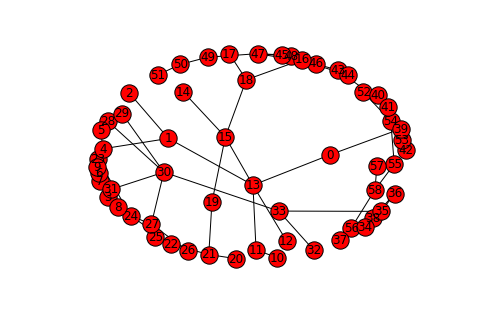

In [47]:
    nx.draw(graph, with_labels=True)
    plt.show()

In [48]:
headTail

[('13', '1'),
 ('1', '2'),
 ('4', '3'),
 ('1', '4'),
 ('4', '5'),
 ('4', '6'),
 ('4', '7'),
 ('9', '8'),
 ('7', '9'),
 ('11', '10'),
 ('13', '11'),
 ('13', '12'),
 ('0', '13'),
 ('15', '14'),
 ('13', '15'),
 ('18', '16'),
 ('18', '17'),
 ('15', '18'),
 ('15', '19'),
 ('21', '20'),
 ('19', '21'),
 ('21', '22'),
 ('24', '23'),
 ('22', '24'),
 ('27', '25'),
 ('27', '26'),
 ('24', '27'),
 ('30', '28'),
 ('30', '29'),
 ('27', '30'),
 ('30', '31'),
 ('33', '32'),
 ('30', '33'),
 ('35', '34'),
 ('33', '35'),
 ('35', '36'),
 ('38', '37'),
 ('36', '38'),
 ('0', '39'),
 ('41', '40'),
 ('39', '41'),
 ('41', '42'),
 ('41', '43'),
 ('45', '44'),
 ('43', '45'),
 ('47', '46'),
 ('45', '47'),
 ('47', '48'),
 ('47', '49'),
 ('49', '50'),
 ('50', '51'),
 ('54', '52'),
 ('54', '53'),
 ('39', '54'),
 ('54', '55'),
 ('58', '56'),
 ('58', '57'),
 ('55', '58')]